## Dependencies

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

##  Load the dataset
### Update file path accordingly

In [23]:
df = pd.read_csv('basketball.csv')

## Data Exploration
### show basic info and check for missing values

In [24]:
print(df.info())  # Check column types and missing data
print(df.describe())  # Statistical summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Edition Year  710 non-null    int64 
 1   Team 1        710 non-null    object
 2   Team 2        710 non-null    object
 3   Score 1       710 non-null    int64 
 4   Score 2       710 non-null    int64 
 5   Winner        710 non-null    object
dtypes: int64(3), object(3)
memory usage: 25.0+ KB
None
       Edition Year     Score 1     Score 2
count    710.000000  710.000000  710.000000
mean    1989.577465   79.695775   77.823944
std       16.764243   18.296349   17.741960
min     1964.000000    2.000000    0.000000
25%     1976.000000   68.000000   66.000000
50%     1988.000000   79.000000   77.000000
75%     2004.000000   91.000000   89.000000
max     2020.000000  156.000000  129.000000


## Data Preprocessing
### Handle missing values 

In [25]:
# Handle missing values for numeric columns only
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Convert categorical columns to numerical (e.g., team names)
label_encoder = LabelEncoder()
df['Team 1'] = label_encoder.fit_transform(df['Team 1'])
df['Team 2'] = label_encoder.fit_transform(df['Team 2'])

# Create a new target column: win/loss for team_1 (binary classification)
df['match_result'] = np.where(df['Score 1'] > df['Score 2'], 1, 0)

# Drop unnecessary columns (like scores if predicting only win/loss)
df.drop(['Score 1', 'Score 2'], axis=1, inplace=True)

## Feature Engineering


In [26]:
# Ensure 'location' column exists
if 'location' not in df.columns:
	df['location'] = 'home'  # or set to a default value like 'away'

# Create cumulative win columns for each team
df['team_1_wins'] = df.groupby('Team 1')['match_result'].cumsum()
df['team_2_wins'] = df.groupby('Team 2')['match_result'].transform(lambda x: x.cumsum().shift().fillna(0))

# Calculate recent wins ratio and home advantage
df['team_1_recent_wins'] = df['team_1_wins'] / (df['team_1_wins'] + df['team_2_wins'])
df['home_advantage'] = np.where(df['location'] == 'home', 1, 0)

## Define Features and Target

In [27]:

X = df[['Team 1', 'Team 2', 'team_1_recent_wins', 'home_advantage']]
y = df['match_result']

## Train-Test Split


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Initialize XGBoost Model


In [29]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

## Hyperparameter Tuning (optional)


In [30]:
param_grid = {
    'max_depth': [3, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.7]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 7, 9],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

## Best model from Grid Search


In [31]:
best_model = grid_search.best_estimator_

## Make Predictions

In [32]:
y_pred = best_model.predict(X_test)

## Evaluate the Model

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 73.94%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.59      0.69        70
           1       0.69      0.89      0.78        72

    accuracy                           0.74       142
   macro avg       0.76      0.74      0.73       142
weighted avg       0.76      0.74      0.73       142



## Feature Importance
### for model interpretability

Matplotlib is building the font cache; this may take a moment.


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

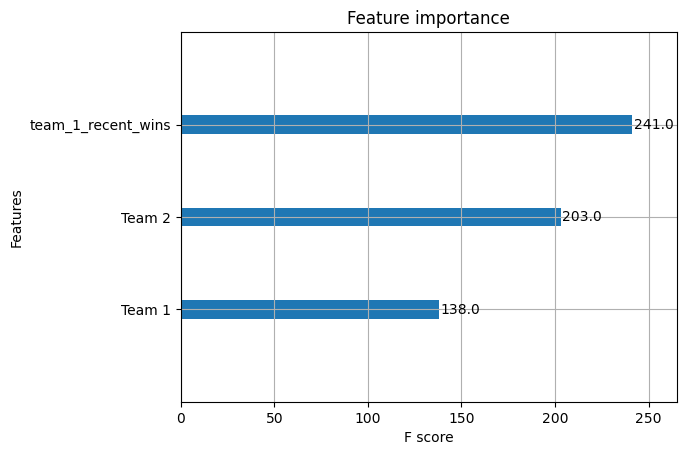

In [20]:
xgb.plot_importance(best_model)